## Evaluate Filtering - SNPs in introgression project exome capture dataset

Inspired by GATK's joint annotation plots of known vs novel variants and "A tour of scikit-allel" plotting.

Plots distributions of various annotations for a single chromosome.

### Setup

Add code block that allows multiple plots to "float around" and fit within window size

In [1]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [2]:
import numpy as np
from numpy import percentile
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; print('seaborn', sns.__version__)
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)
from IPython.display import display_html

seaborn 0.12.2
scikit-allel 1.3.5


---
### VCF filepath with custom annotations

VCF filepath with custom annotations for plotting
- `known_snp` vs `novel_snp`
- `filtered` vs `retained_filt1` vs `retained_filt2`

Custom annotations should be in a single file, please see the script `scikit_allel_plot_prep.sh` for how this VCF with custom annotations was generated.

In [3]:
fp_ann_h5 = "/panfs/jay/groups/9/morrellp/shared/Datasets/Alignments/introgression_project/all_dom_and_wild/Filtered/scikit_allel_files/chr1H_Genome_Random_Intervals_1Mx100bp.h5"


chr1H random intervals:

In [4]:
# Load data
callset = h5py.File(fp_ann_h5, mode='r')
callset

<HDF5 file "chr1H_Genome_Random_Intervals_1Mx100bp.h5" (mode r)>

In [5]:
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'QD', 'FS',
                                            'SOR', 'MQ', 'MQRankSum', 'ReadPosRankSum', 'VAR_KNOWN', 'VAR_FILT'])
variants

<VariantChunkedTable shape=(2800779,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=245.7M cbytes=70.6M cratio=3.5
   values=h5py._hl.group.Group>

In [6]:
# Downsample variants for plotting purposes
#variants_ds = variants[:][::800]
#variants_ds

In [7]:
# Pull out only known SNPs
known_snps = variants.query('VAR_KNOWN == "known"')
known_snps

<VariantChunkedTable shape=(879,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=79.0K cbytes=34.8K cratio=2.3
   values=h5py._hl.files.File>

In [8]:
# Downsample novel variants for plotting purposes
novel_snps = variants.query('VAR_KNOWN == "novel"')[:][::200]
novel_snps

<VariantTable shape=(14000,) dtype=(numpy.record, [('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')])>
[('chr1H_part1',     49448, 'G', ['C', 'A', ''], 27935.1 , 12841, 34.49, 3.199, 0.37 , 58.31,  0.857,  0.881, 'novel', 'filtered')
 ('chr1H_part1',     83755, 'G', ['C', '', ''],  1200.8 ,  1987, 32.46, 0.   , 4.112, 60.  ,  0.   , -0.887, 'novel', 'filtered')
 ('chr1H_part1',    138750, 'A', ['*', 'G', ''],  1031.25, 13124, 17.19, 0.   , 3.841, 52.27,    nan,    nan, 'novel', 'filtered')
 ...
 ('chr1H_part2', 309939173, 'G', ['C', 'T', ''],   242.14,    57, 27.64, 0.   , 2.833, 36.44,    nan,    nan, 'novel', 'filtered')
 ('chr1H_part2', 309953665, 'G', ['C', 'A', 'T'],  1193.76,   132, 24.4 , 0.   , 0.499, 31.18, -0.967, -0.967, 'novel', 'filtered')
 ('chr1H_part2', 309957217, 'G', ['*', 'A', ''],    73.39,  3220,  0.67, 6.882, 1.639, 30.08, -0.674, -1.017, 'novel', 'filtered')]

In [9]:
# GATK's recommended SNP cutoffs (note this is just for use as a reference point in plots)
# Filter out QD < 2
qd_cutoff = 2

# Filter out FS > 60
fs_cutoff = 60

# Filter out SOR > 3
sor_cutoff = 3

# Filter out MQ < 40
mq_cutoff = 40

# Filter out MQRankSum < -12.5
mqranksum_cutoff = -12.5

# Filter out ReadPosRankSum < -8.0
readposranksum_cutoff = -8.0

---
### Summary stats

In [10]:
def summary_stats(x, f, low, high):
    minimum = np.min(x)
    maximum = np.max(x)
    avg = np.mean(x)
    dev = np.std(x)
    low_thresh = np.percentile(x, low)
    high_thresh = np.percentile(x, high)
    print("Given %d variants, we have the following stats for %s:\nMean: %f\
            \nMinimum: %f\nMaximum: %f\nSt. Deviation: %f\n%dth percentile: %f\n%dth percentile: %f\n"
          % (len(x), f, avg, minimum, maximum, dev, low, low_thresh, high, high_thresh))

In [11]:
# Summary of variants
# Remove nan values
qd = variants['QD'][:]
summary_stats(qd[~np.isnan(qd)], 'QD', 5, 95)
summary_stats(variants['FS'][:], 'FS', 5, 95)
summary_stats(variants['SOR'][:], 'SOR', 5, 95)
# Remove nan values
mq = variants['MQ'][:]
summary_stats(mq[~np.isnan(mq)], 'MQ', 5, 95)
# Remove nan values
mqranksum = variants['MQRankSum'][:]
summary_stats(mqranksum[~np.isnan(mqranksum)], 'MQRankSum', 5, 95)
# Remove nan values
readposranksum = variants['ReadPosRankSum'][:]
summary_stats(readposranksum[~np.isnan(readposranksum)], 'ReadPosRankSum', 5, 95)

Given 2800207 variants, we have the following stats for QD:
Mean: 28.053663            
Minimum: 0.000000
Maximum: 43.150002
St. Deviation: 6.272548
5th percentile: 13.510000
95th percentile: 34.619999

Given 2800779 variants, we have the following stats for FS:
Mean: 0.437856            
Minimum: 0.000000
Maximum: 204.343994
St. Deviation: 2.545906
5th percentile: 0.000000
95th percentile: 2.813000

Given 2800779 variants, we have the following stats for SOR:
Mean: 1.205165            
Minimum: 0.000000
Maximum: 10.330000
St. Deviation: 0.805152
5th percentile: 0.223000
95th percentile: 2.584000

Given 2800350 variants, we have the following stats for MQ:
Mean: 47.454300            
Minimum: 20.000000
Maximum: 60.000000
St. Deviation: 10.973554
5th percentile: 26.309999
95th percentile: 60.000000

Given 584209 variants, we have the following stats for MQRankSum:
Mean: -0.412753            
Minimum: -18.900000
Maximum: 13.680000
St. Deviation: 1.072446
5th percentile: -1.922000
95th pe

---
### Plot joint annotations

Compare known vs novel variants and each level of filtering.

In [12]:
def plot_known_vs_novel(novel_df, known_df, f1, f2, f1min, f1max, f2min, f2max, f1_cutoff, f2_cutoff):
    # Divide into filtered vs retained_filt1 vs retained_filt2
    # filtered
    novel_f1_filt = novel_df.query('VAR_FILT == "filtered"')[f1][:]
    novel_f2_filt = novel_df.query('VAR_FILT == "filtered"')[f2][:]
    # retained_filt1
    novel_f1_retfilt1 = novel_df.query('VAR_FILT == "retained_filt1"')[f1][:]
    novel_f2_retfilt1 = novel_df.query('VAR_FILT == "retained_filt1"')[f2][:]
    # retained_filt2
    novel_f1_retfilt2 = novel_df.query('VAR_FILT == "retained_filt2"')[f1][:]
    novel_f2_retfilt2 = novel_df.query('VAR_FILT == "retained_filt2"')[f2][:]
    
    fig, ax = plt.subplots()
    
    ax.scatter(novel_f1_filt, novel_f2_filt, c='#DAD7CD', alpha=0.2, label='Novel: filtered')
    ax.scatter(novel_f1_retfilt1, novel_f2_retfilt1, c='#8ECAE6', alpha=0.6, label='Novel: retained_filt1')
    ax.scatter(novel_f1_retfilt2, novel_f2_retfilt2, c='#126782', alpha=0.7, label='Novel: retained_filt2')
    #ax.scatter(known_f1, known_f2, c='#F4B266', alpha=0.9, label='Known')
    
    try:
        # filtered
        known_f1_filt = known_df.query('VAR_FILT == "filtered"')[f1][:]
        known_f2_filt = known_df.query('VAR_FILT == "filtered"')[f2][:]
        ax.scatter(known_f1_filt, known_f2_filt, c='#ffd07b', alpha=0.9, label='Known: filtered')
    except:
        pass
    
    try:
        # retained_filt1
        known_f1_retfilt1 = known_df.query('VAR_FILT == "retained_filt1"')[f1][:]
        known_f2_retfilt1 = known_df.query('VAR_FILT == "retained_filt1"')[f2][:]
        ax.scatter(known_f1_retfilt1, known_f2_retfilt1, c='#fd9e02', alpha=0.9, label='Known: retained_filt1')
    except:
        pass
    
    try:
        # retained_filt2
        known_f1_retfilt2 = known_df.query('VAR_FILT == "retained_filt2"')[f1][:]
        known_f2_retfilt2 = known_df.query('VAR_FILT == "retained_filt2"')[f2][:]
        ax.scatter(known_f1_retfilt2, known_f2_retfilt2, c='#b83700', alpha=0.6, label='Known: retained_filt2')
    except:
        pass
    
    ax.legend()
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s vs %s' % (f1, f2))
    
    # Add cutoff lines
    plt.axvline(x=f1_cutoff, color='#4A4A48', linewidth=0.6)
    plt.axhline(y=f2_cutoff, color='#4A4A48', linewidth=0.6)
    
    # Set axes range
    plt.xlim(f1min, f1max)
    plt.ylim(f2min, f2max)

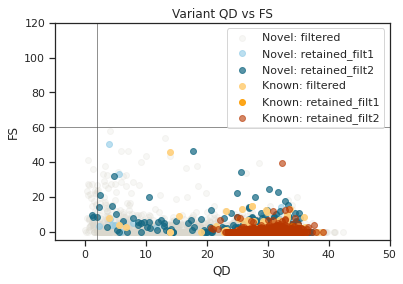

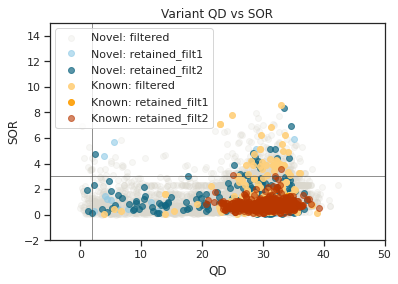

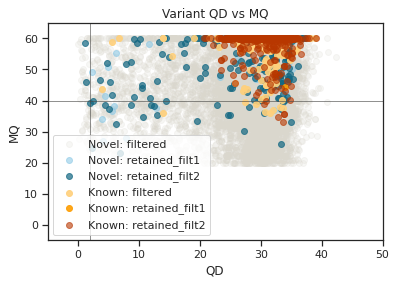

In [13]:
# Idea is to get a sense of the distributions
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='FS', f1min=-5, f1max=50, f2min=-5, f2max=120, f1_cutoff=qd_cutoff, f2_cutoff=fs_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='SOR', f1min=-5, f1max=50, f2min=-2, f2max=15, f1_cutoff=qd_cutoff, f2_cutoff=sor_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='MQ', f1min=-5, f1max=50, f2min=-5, f2max=65, f1_cutoff=qd_cutoff, f2_cutoff=mq_cutoff)

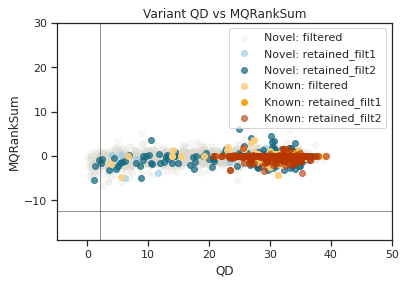

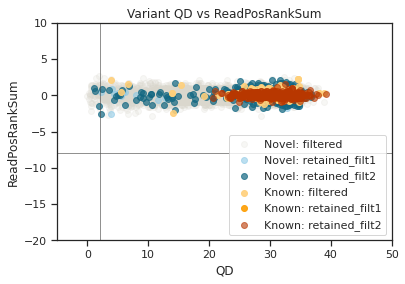

In [14]:
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='MQRankSum', f1min=-5, f1max=50, f2min=-19, f2max=30, f1_cutoff=qd_cutoff, f2_cutoff=mqranksum_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='ReadPosRankSum', f1min=-5, f1max=50, f2min=-20, f2max=10, f1_cutoff=qd_cutoff, f2_cutoff=readposranksum_cutoff)


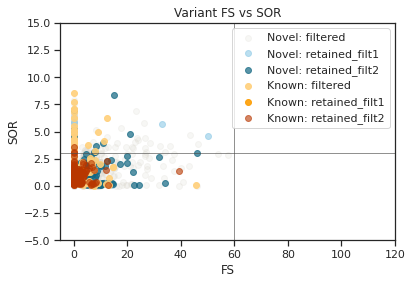

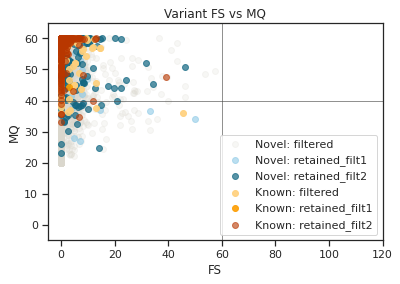

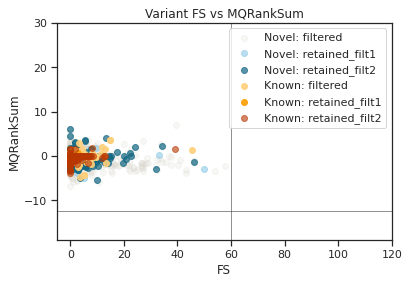

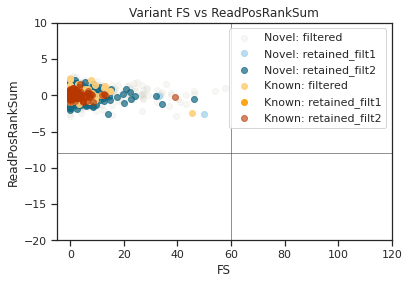

In [15]:
plot_known_vs_novel(novel_snps, known_snps, f1='FS', f2='SOR', f1min=-5, f1max=120, f2min=-5, f2max=15, f1_cutoff=fs_cutoff, f2_cutoff=sor_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='FS', f2='MQ', f1min=-5, f1max=120, f2min=-5, f2max=65, f1_cutoff=fs_cutoff, f2_cutoff=mq_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='FS', f2='MQRankSum', f1min=-5, f1max=120, f2min=-19, f2max=30, f1_cutoff=fs_cutoff, f2_cutoff=mqranksum_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='FS', f2='ReadPosRankSum', f1min=-5, f1max=120, f2min=-20, f2max=10, f1_cutoff=fs_cutoff, f2_cutoff=readposranksum_cutoff)


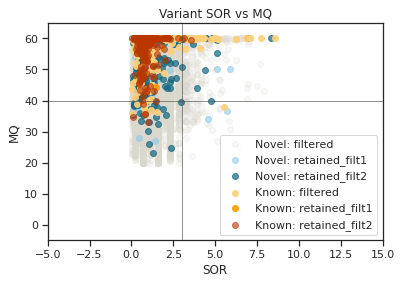

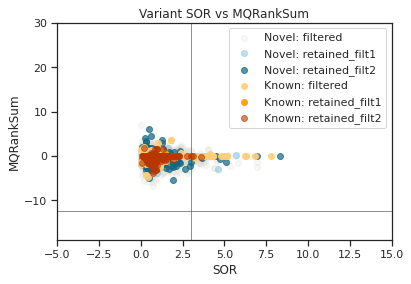

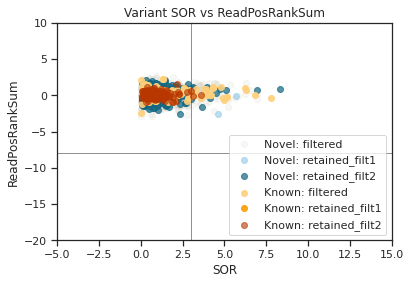

In [16]:
plot_known_vs_novel(novel_snps, known_snps, f1='SOR', f2='MQ', f1min=-5, f1max=15, f2min=-5, f2max=65, f1_cutoff=sor_cutoff, f2_cutoff=mq_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='SOR', f2='MQRankSum', f1min=-5, f1max=15, f2min=-19, f2max=30, f1_cutoff=sor_cutoff, f2_cutoff=mqranksum_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='SOR', f2='ReadPosRankSum', f1min=-5, f1max=15, f2min=-20, f2max=10, f1_cutoff=sor_cutoff, f2_cutoff=readposranksum_cutoff)


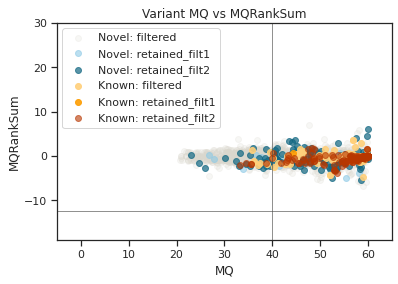

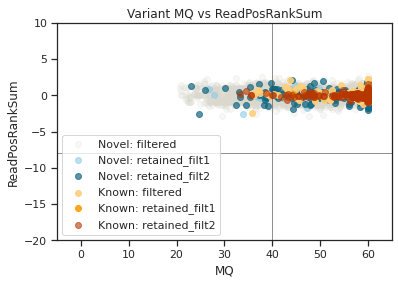

In [17]:
plot_known_vs_novel(novel_snps, known_snps, f1='MQ', f2='MQRankSum', f1min=-5, f1max=65, f2min=-19, f2max=30, f1_cutoff=mq_cutoff, f2_cutoff=mqranksum_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='MQ', f2='ReadPosRankSum', f1min=-5, f1max=65, f2min=-20, f2max=10, f1_cutoff=mq_cutoff, f2_cutoff=readposranksum_cutoff)


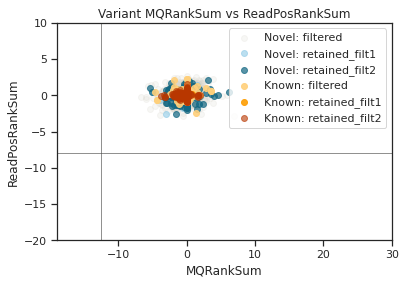

In [18]:
plot_known_vs_novel(novel_snps, known_snps, f1='MQRankSum', f2='ReadPosRankSum',
                    f1min=-19, f1max=30, f2min=-20, f2max=10, f1_cutoff=mqranksum_cutoff, f2_cutoff=readposranksum_cutoff)

---
### Density plots of pass vs fail variants

In [19]:
# Prepare pass vs failed variants
# Pass (includes only "retained_filt2" ann)
pass_variants = variants.query('VAR_FILT == "retained_filt2"')
# Fail (includes "filtered" and "retained_filt1" ann)
fail_variants = variants.query('VAR_FILT != "retained_filt2"')

In [20]:
# Pass filt1 (includes "retained_filt1" and "retained_filt2" ann)
pass_filt1 = variants.query('VAR_FILT != "filtered"')
# Fail filt1 (only includes "filtered" ann)
fail_filt1 = variants.query('VAR_FILT == "filtered"')

In [21]:
vqd_pass = pandas.DataFrame(np.array(pass_variants[['QD', 'VAR_FILT']]))
vqd_pass['PF'] = 'Pass'
vqd_pass

,QD,VAR_FILT,PF
0,23.059999,retained_filt2,Pass
1,33.650002,retained_filt2,Pass
2,27.230000,retained_filt2,Pass
3,29.520000,retained_filt2,Pass
4,33.470001,retained_filt2,Pass
...,...,...,...
69875,32.820000,retained_filt2,Pass
69876,34.360001,retained_filt2,Pass
69877,32.740002,retained_filt2,Pass
69878,35.400002,retained_filt2,Pass


In [22]:
vqd_fail = pandas.DataFrame(np.array(fail_variants[['QD', 'VAR_FILT']]))
vqd_fail['PF'] = 'Fail'
vqd_fail

,QD,VAR_FILT,PF
0,34.490002,filtered,Fail
1,3.600000,filtered,Fail
2,2.410000,filtered,Fail
3,33.509998,filtered,Fail
4,28.350000,filtered,Fail
...,...,...,...
2730894,30.000000,filtered,Fail
2730895,31.389999,filtered,Fail
2730896,24.350000,filtered,Fail
2730897,33.610001,filtered,Fail


In [23]:
vqd = pandas.concat([vqd_pass, vqd_fail]).reset_index()
vqd

,index,QD,VAR_FILT,PF
0,0,23.059999,retained_filt2,Pass
1,1,33.650002,retained_filt2,Pass
2,2,27.230000,retained_filt2,Pass
3,3,29.520000,retained_filt2,Pass
4,4,33.470001,retained_filt2,Pass
...,...,...,...,...
2800774,2730894,30.000000,filtered,Fail
2800775,2730895,31.389999,filtered,Fail
2800776,2730896,24.350000,filtered,Fail
2800777,2730897,33.610001,filtered,Fail


<AxesSubplot: xlabel='QD', ylabel='Density'>

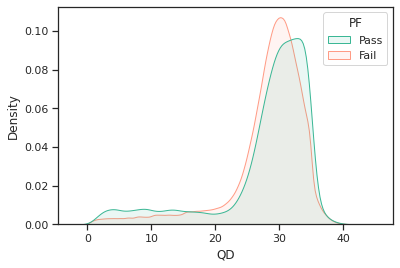

In [24]:
sns.kdeplot(data=vqd, x='QD', hue='PF', fill=True,
            common_norm=False, alpha=0.1, palette=['#3ab795', '#ff9b85'])

In [25]:
def plot_pass_vs_fail(var_pass, var_fail, ann, ann_cutoff):
    # Prepare pass vs fail labels for current annotation
    # Pass
    v_pass = pandas.DataFrame(np.array(var_pass[[ann, 'VAR_FILT']]))
    v_pass['PF'] = 'Pass'
    # Fail
    v_fail = pandas.DataFrame(np.array(var_fail[[ann, 'VAR_FILT']]))
    v_fail['PF'] = 'Fail'
    # Combine into one dataframe
    vdf = pandas.concat([v_pass, v_fail]).reset_index()
    
    fig, ax = plt.subplots()
    
    sns.kdeplot(data=vdf, x=ann, hue='PF', fill=True,
                common_norm=False,
                alpha=0.1, palette=['#3ab795', '#ff9b85'])
    
    plt.legend(["Fail", "Pass"])
    ax.set_xlabel(ann)
    ax.set_ylabel('Density')
    ax.set_title('Variant %s, pass vs failed' % (ann))
    
    # Add cutoff line
    plt.axvline(x=ann_cutoff, color='#4A4A48', linewidth=0.6)

Pass vs Fail variants after filtering pass 1.

In [26]:
print("For reference, here are GATK's recommended hard cutoffs (Note: these hard cutoffs aren't actually used for filtering here).")
print("Variants fail filtering if:")
print("QD < ", qd_cutoff, "; FS > ", fs_cutoff, "; SOR > ", sor_cutoff, "; MQ < ",
      mq_cutoff, "; MQRankSum < ", mqranksum_cutoff, "; ReadPosRankSum < ", readposranksum_cutoff)

For reference, here are GATK's recommended hard cutoffs (Note: these hard cutoffs aren't actually used for filtering here).
Variants fail filtering if:
QD <  2 ; FS >  60 ; SOR >  3 ; MQ <  40 ; MQRankSum <  -12.5 ; ReadPosRankSum <  -8.0


Pass vs Fail variants after filtering pass 1.

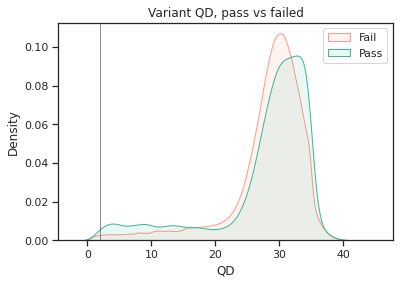

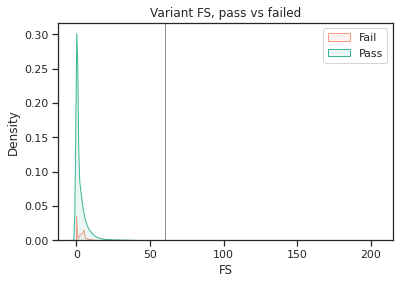

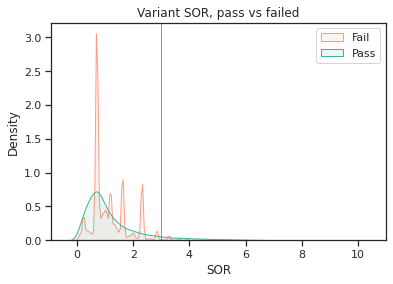

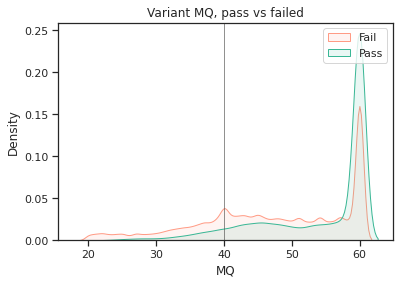

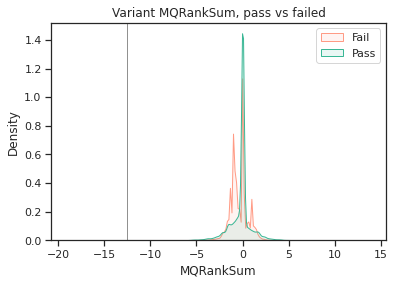

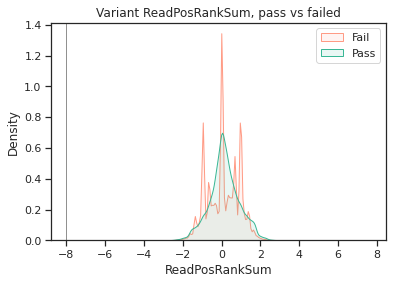

In [27]:
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='QD', ann_cutoff=qd_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='FS', ann_cutoff=fs_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='SOR', ann_cutoff=sor_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='MQ', ann_cutoff=mq_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='MQRankSum', ann_cutoff=mqranksum_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='ReadPosRankSum', ann_cutoff=readposranksum_cutoff)

Pass vs fail filtering after pass 2.

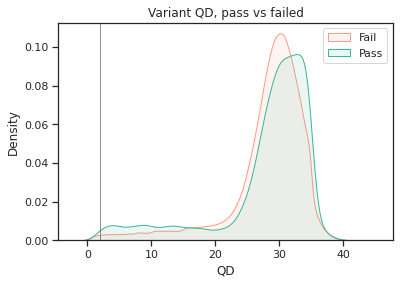

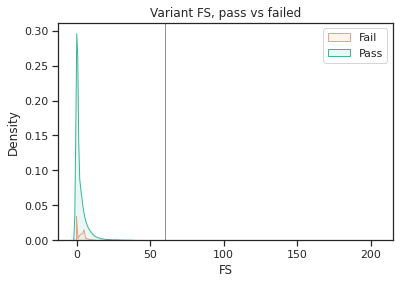

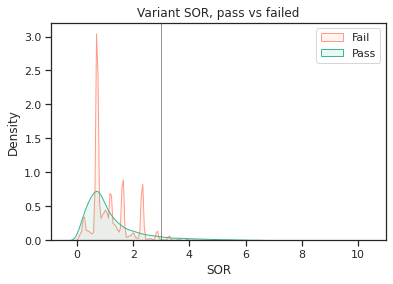

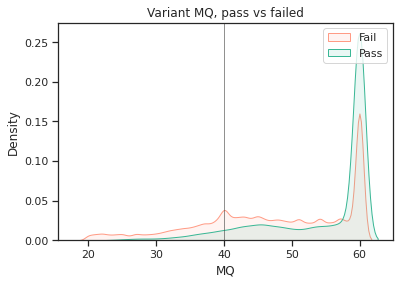

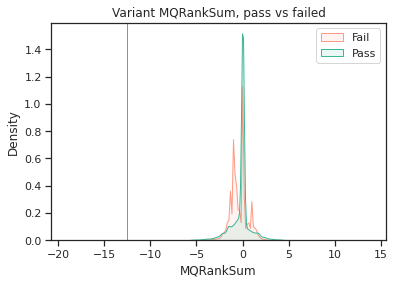

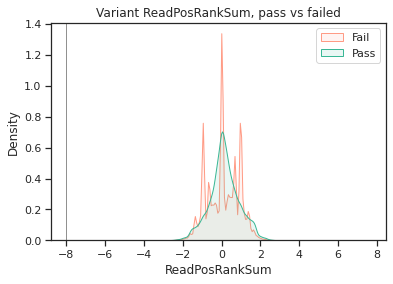

In [28]:
plot_pass_vs_fail(pass_variants, fail_variants, ann='QD', ann_cutoff=qd_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='FS', ann_cutoff=fs_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='SOR', ann_cutoff=sor_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='MQ', ann_cutoff=mq_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='MQRankSum', ann_cutoff=mqranksum_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='ReadPosRankSum', ann_cutoff=readposranksum_cutoff)

---
### Plot joint annotations and their relationship with Ti/Tv

Ti/Tv is not a simple variable and so some care is required when interpreting these plots.

These plots were inspired by ["A tour of scikit-allel"](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html)

In [29]:
def locate_transitions(x):
    x = np.asarray(x)
    return (x == 'AG') | (x == 'GA') | (x == 'CT') | (x == 'TC')

In [30]:
# Compute Ti/Tv
def ti_tv(x):
    if len(x) == 0:
        return np.nan
    is_ti = locate_transitions(x)
    n_ti = np.count_nonzero(is_ti)
    n_tv = np.count_nonzero(~is_ti)
    if n_tv > 0:
        return n_ti / n_tv
    else:
        return np.nan

In [31]:
def plot_joint_ti_tv(variants, f1, f2, downsample, f1_cutoff, f2_cutoff, gridsize=20, mincnt=20, vmin=0.5, vmax=2.0, extent=None):
    mutations = np.char.add(variants['REF'][:].astype(str), variants['ALT'][:, 0])
    fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=10)
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    C = mutations[::downsample]
    im = ax.hexbin(x, y, C=C, reduce_C_function=ti_tv, mincnt=mincnt, extent=extent,
                   gridsize=gridsize, cmap='jet', vmin=vmin, vmax=vmax)
    # Add cutoff lines
    plt.axvline(x=f1_cutoff, color='#4A4A48', linewidth=0.6)
    plt.axhline(y=f2_cutoff, color='#4A4A48', linewidth=0.6)
    fig.colorbar(im)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s and Ti/Tv' % (f1, f2))

In [32]:
print("For reference, here are GATK's recommended hard cutoffs (Note: these hard cutoffs aren't actually used for filtering here).")
print("Variants fail filtering if:")
print("QD < ", qd_cutoff, "; FS > ", fs_cutoff, "; SOR > ", sor_cutoff, "; MQ < ",
      mq_cutoff, "; MQRankSum < ", mqranksum_cutoff, "; ReadPosRankSum < ", readposranksum_cutoff)

For reference, here are GATK's recommended hard cutoffs (Note: these hard cutoffs aren't actually used for filtering here).
Variants fail filtering if:
QD <  2 ; FS >  60 ; SOR >  3 ; MQ <  40 ; MQRankSum <  -12.5 ; ReadPosRankSum <  -8.0


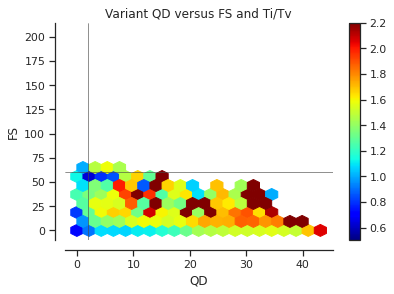

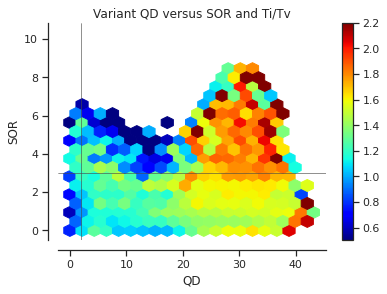

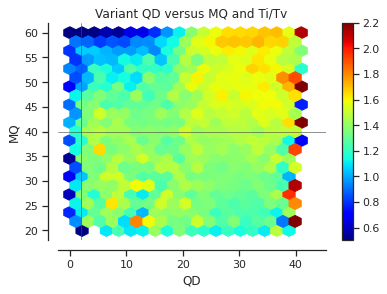

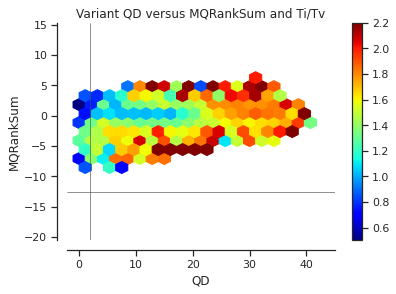

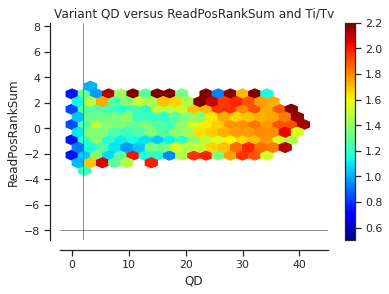

In [33]:
plot_joint_ti_tv(variants, 'QD', 'FS', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=fs_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants, 'QD', 'SOR', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=sor_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants, 'QD', 'MQ', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=mq_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants, 'QD', 'MQRankSum', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=mqranksum_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants, 'QD', 'ReadPosRankSum', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=readposranksum_cutoff, mincnt=20, vmax=2.2)

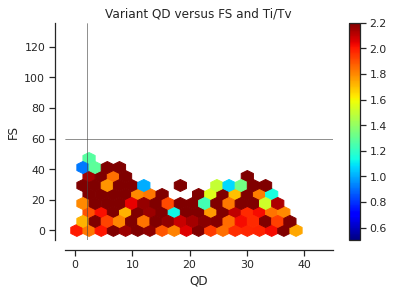

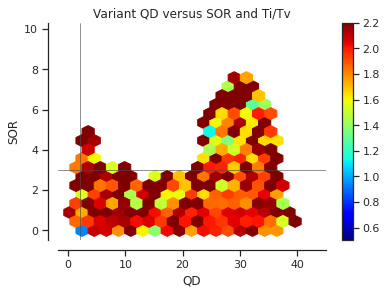

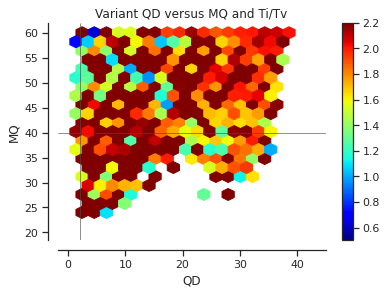

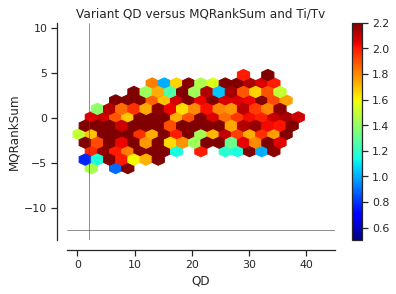

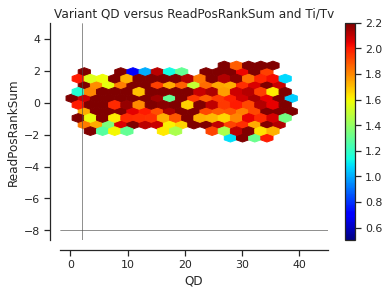

In [34]:
variants_filt1 = variants.query('VAR_FILT != "filtered"')

plot_joint_ti_tv(variants_filt1, 'QD', 'FS', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=fs_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt1, 'QD', 'SOR', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=sor_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt1, 'QD', 'MQ', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=mq_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt1, 'QD', 'MQRankSum', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=mqranksum_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt1, 'QD', 'ReadPosRankSum', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=readposranksum_cutoff, mincnt=20, vmax=2.2)

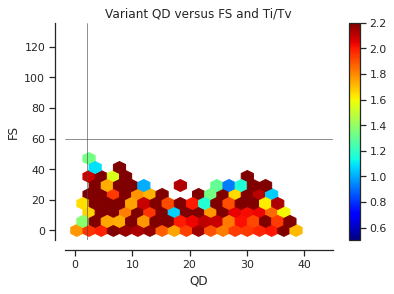

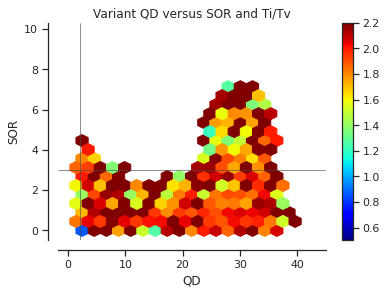

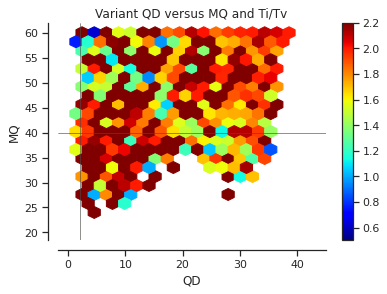

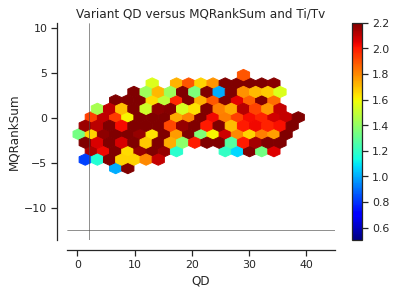

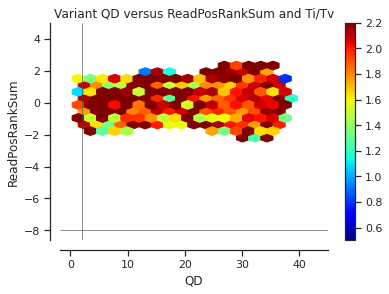

In [35]:
variants_filt2 = variants_filt1.query('VAR_FILT != "retained_filt1"')

plot_joint_ti_tv(variants_filt2, 'QD', 'FS', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=fs_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt2, 'QD', 'SOR', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=sor_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt2, 'QD', 'MQ', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=mq_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt2, 'QD', 'MQRankSum', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=mqranksum_cutoff, mincnt=20, vmax=2.2)
plot_joint_ti_tv(variants_filt2, 'QD', 'ReadPosRankSum', downsample=1, f1_cutoff=qd_cutoff, f2_cutoff=readposranksum_cutoff, mincnt=20, vmax=2.2)

---
## Explore all known variants

Purpose is to get a sense of the distributions of known variants that are getting filtered out.

In [36]:
# Only known variants genome-wide
fp_ann_h5_known = "/panfs/jay/groups/9/morrellp/shared/Datasets/Alignments/introgression_project/all_dom_and_wild/Filtered/scikit_allel_files/only_known-dom_and_wild_snps.vcf.h5"


In [37]:
# Load data
callset_known = h5py.File(fp_ann_h5_known, mode='r')

In [38]:
variants_known = allel.VariantChunkedTable(callset_known['variants'], 
                                     names=['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'QD', 'FS',
                                            'SOR', 'MQ', 'MQRankSum', 'ReadPosRankSum', 'VAR_KNOWN', 'VAR_FILT'])

In [39]:
# Summary of variants
# Remove nan values
qd = variants_known['QD'][:]
summary_stats(qd[~np.isnan(qd)], 'QD', 5, 95)
summary_stats(variants_known['FS'][:], 'FS', 5, 95)
summary_stats(variants_known['SOR'][:], 'SOR', 5, 95)
# Remove nan values
mq = variants_known['MQ'][:]
summary_stats(mq[~np.isnan(mq)], 'MQ', 5, 95)
# Remove nan values
mqranksum = variants_known['MQRankSum'][:]
summary_stats(mqranksum[~np.isnan(mqranksum)], 'MQRankSum', 5, 95)
# Remove nan values
readposranksum = variants_known['ReadPosRankSum'][:]
summary_stats(readposranksum[~np.isnan(readposranksum)], 'ReadPosRankSum', 5, 95)

Given 42272 variants, we have the following stats for QD:
Mean: 30.272427            
Minimum: 0.320000
Maximum: 44.029999
St. Deviation: 3.431472
5th percentile: 24.920000
95th percentile: 34.910000

Given 42272 variants, we have the following stats for FS:
Mean: 0.934947            
Minimum: 0.000000
Maximum: 98.899002
St. Deviation: 3.140804
5th percentile: 0.000000
95th percentile: 4.498450

Given 42272 variants, we have the following stats for SOR:
Mean: 0.979886            
Minimum: 0.003000
Maximum: 10.397000
St. Deviation: 0.926085
5th percentile: 0.305000
95th percentile: 2.860450

Given 42272 variants, we have the following stats for MQ:
Mean: 58.027035            
Minimum: 21.000000
Maximum: 60.000000
St. Deviation: 4.957628
5th percentile: 45.369999
95th percentile: 60.000000

Given 41005 variants, we have the following stats for MQRankSum:
Mean: -0.139597            
Minimum: -9.358000
Maximum: 9.370000
St. Deviation: 0.600170
5th percentile: -1.379800
95th percentile: 0.0

Get a sense of the proportion of known variants that get filtered out.

In [40]:
variants_known

<VariantChunkedTable shape=(42272,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=3.7M cbytes=1.4M cratio=2.7
   values=h5py._hl.group.Group>

In [41]:
variants_known.query('VAR_FILT == "filtered"')

<VariantChunkedTable shape=(13021,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=1.1M cbytes=436.0K cratio=2.7
   values=h5py._hl.files.File>

In [42]:
variants_known.query('VAR_FILT == "retained_filt1"')

<VariantChunkedTable shape=(724,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=65.0K cbytes=26.7K cratio=2.4
   values=h5py._hl.files.File>

In [43]:
variants_known.query('VAR_FILT == "retained_filt2"')

<VariantChunkedTable shape=(28527,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=2.5M cbytes=914.4K cratio=2.8
   values=h5py._hl.files.File>

Compare levels of filtering for known variants genome-wide.

In [44]:
def plot_filtering_levels(known_df, f1, f2, f1min, f1max, f2min, f2max, f1_cutoff, f2_cutoff):
    fig, ax = plt.subplots()
    
    try:
        # filtered
        known_f1_filt = known_df.query('VAR_FILT == "filtered"')[f1][:]
        known_f2_filt = known_df.query('VAR_FILT == "filtered"')[f2][:]
        ax.scatter(known_f1_filt, known_f2_filt, c='#DAD7CD', alpha=0.3, label='Known: filtered')
    except:
        pass
    
    try:
        # retained_filt2
        known_f1_retfilt2 = known_df.query('VAR_FILT == "retained_filt2"')[f1][:]
        known_f2_retfilt2 = known_df.query('VAR_FILT == "retained_filt2"')[f2][:]
        ax.scatter(known_f1_retfilt2, known_f2_retfilt2, c='#b83700', alpha=0.8, label='Known: retained_filt2')
    except:
        pass
    
    try:
        # retained_filt1
        known_f1_retfilt1 = known_df.query('VAR_FILT == "retained_filt1"')[f1][:]
        known_f2_retfilt1 = known_df.query('VAR_FILT == "retained_filt1"')[f2][:]
        ax.scatter(known_f1_retfilt1, known_f2_retfilt1, c='#ffd07b', alpha=0.7, label='Known: retained_filt1')
    except:
        pass
    
    ax.legend()
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s vs %s' % (f1, f2))
    
    # Add cutoff lines
    plt.axvline(x=f1_cutoff, color='#4A4A48', linewidth=0.6)
    plt.axhline(y=f2_cutoff, color='#4A4A48', linewidth=0.6)
    
    # Set axes range
    plt.xlim(f1min, f1max)
    plt.ylim(f2min, f2max)

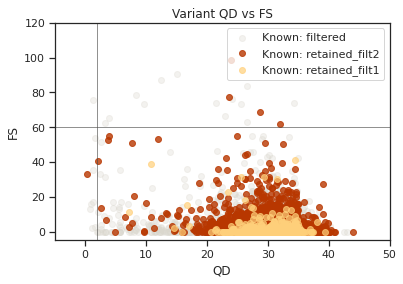

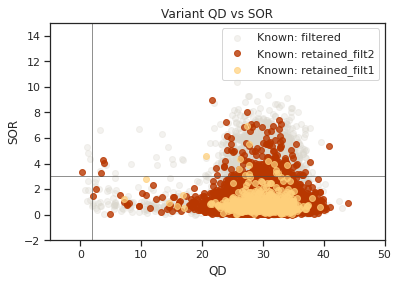

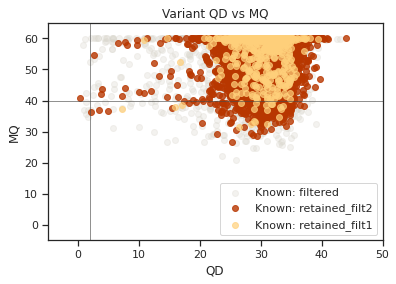

In [45]:
plot_filtering_levels(variants_known, f1='QD', f2='FS', f1min=-5, f1max=50, f2min=-5, f2max=120, f1_cutoff=qd_cutoff, f2_cutoff=fs_cutoff)
plot_filtering_levels(variants_known, f1='QD', f2='SOR', f1min=-5, f1max=50, f2min=-2, f2max=15, f1_cutoff=qd_cutoff, f2_cutoff=sor_cutoff)
plot_filtering_levels(variants_known, f1='QD', f2='MQ', f1min=-5, f1max=50, f2min=-5, f2max=65, f1_cutoff=qd_cutoff, f2_cutoff=mq_cutoff)

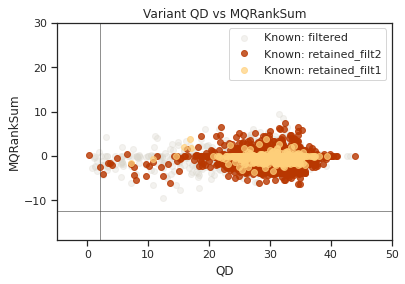

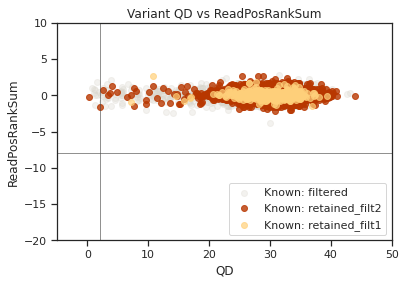

In [46]:
plot_filtering_levels(variants_known, f1='QD', f2='MQRankSum', f1min=-5, f1max=50, f2min=-19, f2max=30, f1_cutoff=qd_cutoff, f2_cutoff=mqranksum_cutoff)
plot_filtering_levels(variants_known, f1='QD', f2='ReadPosRankSum', f1min=-5, f1max=50, f2min=-20, f2max=10, f1_cutoff=qd_cutoff, f2_cutoff=readposranksum_cutoff)


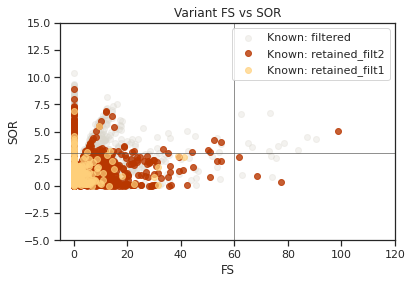

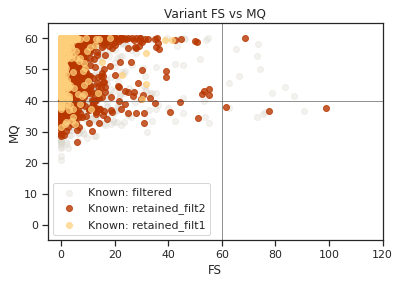

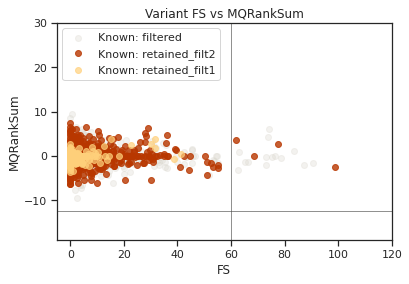

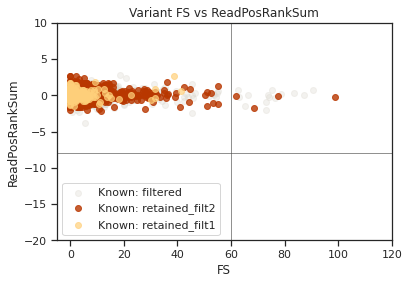

In [47]:
plot_filtering_levels(variants_known, f1='FS', f2='SOR', f1min=-5, f1max=120, f2min=-5, f2max=15, f1_cutoff=fs_cutoff, f2_cutoff=sor_cutoff)
plot_filtering_levels(variants_known, f1='FS', f2='MQ', f1min=-5, f1max=120, f2min=-5, f2max=65, f1_cutoff=fs_cutoff, f2_cutoff=mq_cutoff)
plot_filtering_levels(variants_known, f1='FS', f2='MQRankSum', f1min=-5, f1max=120, f2min=-19, f2max=30, f1_cutoff=fs_cutoff, f2_cutoff=mqranksum_cutoff)
plot_filtering_levels(variants_known, f1='FS', f2='ReadPosRankSum', f1min=-5, f1max=120, f2min=-20, f2max=10, f1_cutoff=fs_cutoff, f2_cutoff=readposranksum_cutoff)


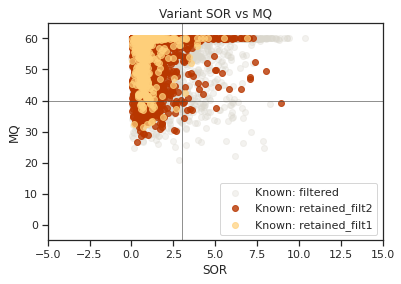

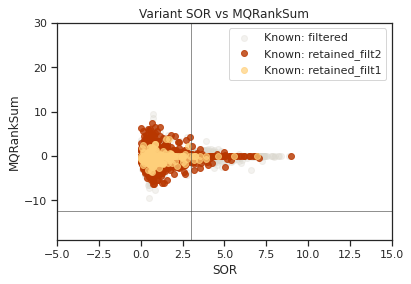

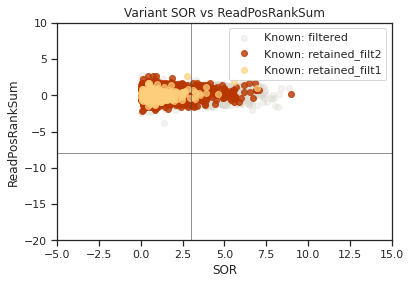

In [48]:
plot_filtering_levels(variants_known, f1='SOR', f2='MQ', f1min=-5, f1max=15, f2min=-5, f2max=65, f1_cutoff=sor_cutoff, f2_cutoff=mq_cutoff)
plot_filtering_levels(variants_known, f1='SOR', f2='MQRankSum', f1min=-5, f1max=15, f2min=-19, f2max=30, f1_cutoff=sor_cutoff, f2_cutoff=mqranksum_cutoff)
plot_filtering_levels(variants_known, f1='SOR', f2='ReadPosRankSum', f1min=-5, f1max=15, f2min=-20, f2max=10, f1_cutoff=sor_cutoff, f2_cutoff=readposranksum_cutoff)


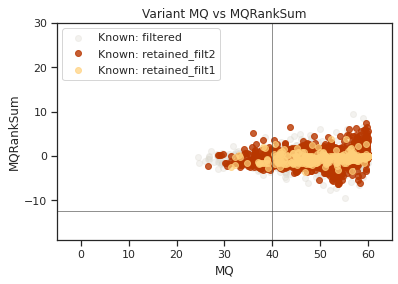

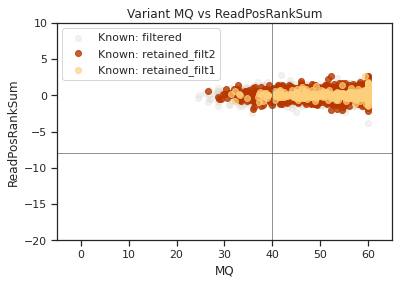

In [49]:
plot_filtering_levels(variants_known, f1='MQ', f2='MQRankSum', f1min=-5, f1max=65, f2min=-19, f2max=30, f1_cutoff=mq_cutoff, f2_cutoff=mqranksum_cutoff)
plot_filtering_levels(variants_known, f1='MQ', f2='ReadPosRankSum', f1min=-5, f1max=65, f2min=-20, f2max=10, f1_cutoff=mq_cutoff, f2_cutoff=readposranksum_cutoff)


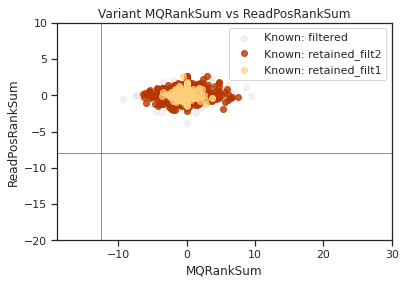

In [50]:
plot_filtering_levels(variants_known, f1='MQRankSum', f2='ReadPosRankSum',
                    f1min=-19, f1max=30, f2min=-20, f2max=10, f1_cutoff=mqranksum_cutoff, f2_cutoff=readposranksum_cutoff)

---
### Density plots of pass vs fail variants

In [51]:
# Prepare pass vs failed variants
# Pass (includes only "retained_filt2" ann)
pass_known_variants = variants_known.query('VAR_FILT == "retained_filt2"')
# Fail (includes "filtered" and "retained_filt1" ann)
fail_known_variants = variants_known.query('VAR_FILT != "retained_filt2"')

In [52]:
pass_known_variants

<VariantChunkedTable shape=(28527,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=2.5M cbytes=914.4K cratio=2.8
   values=h5py._hl.files.File>

In [53]:
fail_known_variants

<VariantChunkedTable shape=(13745,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=1.2M cbytes=460.3K cratio=2.7
   values=h5py._hl.files.File>

In [54]:
variants_known

<VariantChunkedTable shape=(42272,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('MQ', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=3.7M cbytes=1.4M cratio=2.7
   values=h5py._hl.group.Group>

In [55]:
# Pass filt1 (includes "retained_filt1" and "retained_filt2" ann)
pass_known_filt1 = variants_known.query('VAR_FILT != "filtered"')
# Fail filt1 (only includes "filtered" ann)
fail_known_filt1 = variants_known.query('VAR_FILT == "filtered"')

Pass vs Fail variants after filtering pass 1.

In [56]:
print("For reference, here are GATK's recommended hard cutoffs (Note: these hard cutoffs aren't actually used for filtering here).")
print("Variants fail filtering if:")
print("QD < ", qd_cutoff, "; FS > ", fs_cutoff, "; SOR > ", sor_cutoff, "; MQ < ",
      mq_cutoff, "; MQRankSum < ", mqranksum_cutoff, "; ReadPosRankSum < ", readposranksum_cutoff)

For reference, here are GATK's recommended hard cutoffs (Note: these hard cutoffs aren't actually used for filtering here).
Variants fail filtering if:
QD <  2 ; FS >  60 ; SOR >  3 ; MQ <  40 ; MQRankSum <  -12.5 ; ReadPosRankSum <  -8.0


Pass vs Fail variants after filtering pass 1.

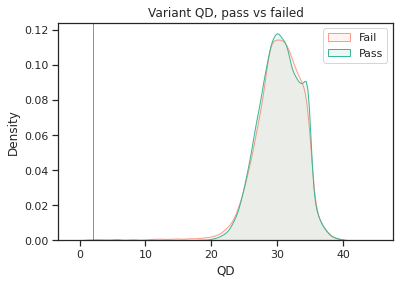

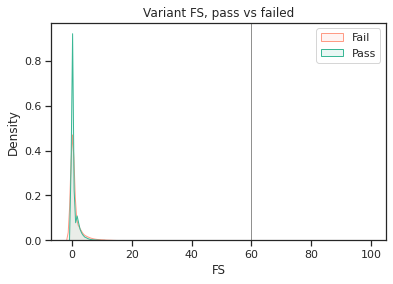

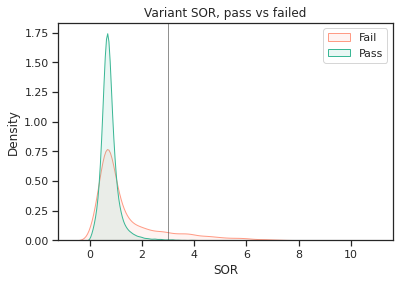

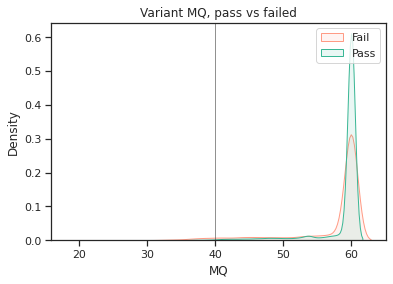

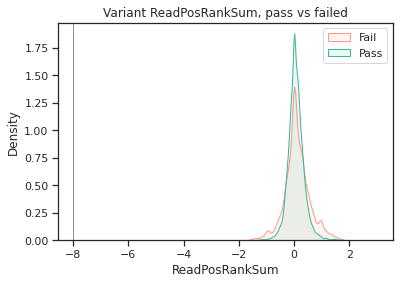

In [57]:
plot_pass_vs_fail(pass_known_filt1, fail_known_filt1, ann='QD', ann_cutoff=qd_cutoff)
plot_pass_vs_fail(pass_known_filt1, fail_known_filt1, ann='FS', ann_cutoff=fs_cutoff)
plot_pass_vs_fail(pass_known_filt1, fail_known_filt1, ann='SOR', ann_cutoff=sor_cutoff)
plot_pass_vs_fail(pass_known_filt1, fail_known_filt1, ann='MQ', ann_cutoff=mq_cutoff)
#plot_pass_vs_fail(pass_known_filt1, fail_known_filt1, ann='MQRankSum', ann_cutoff=mqranksum_cutoff)
plot_pass_vs_fail(pass_known_filt1, fail_known_filt1, ann='ReadPosRankSum', ann_cutoff=readposranksum_cutoff)

Pass vs fail filtering after pass 2.

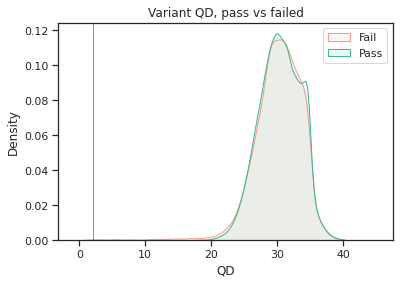

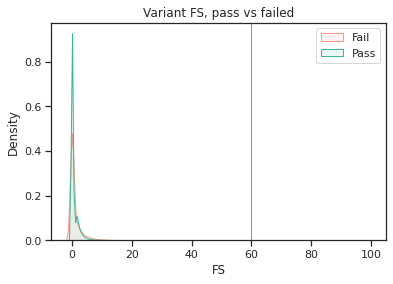

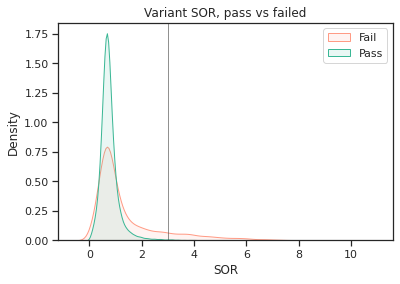

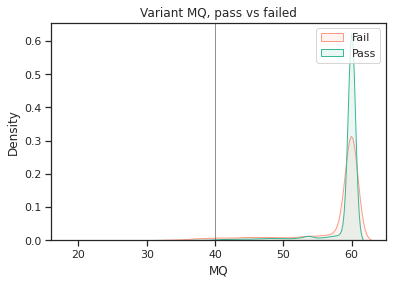

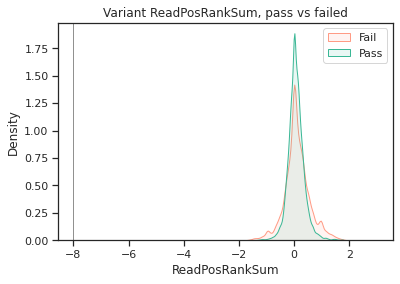

In [58]:
plot_pass_vs_fail(pass_known_variants, fail_known_variants, ann='QD', ann_cutoff=qd_cutoff)
plot_pass_vs_fail(pass_known_variants, fail_known_variants, ann='FS', ann_cutoff=fs_cutoff)
plot_pass_vs_fail(pass_known_variants, fail_known_variants, ann='SOR', ann_cutoff=sor_cutoff)
plot_pass_vs_fail(pass_known_variants, fail_known_variants, ann='MQ', ann_cutoff=mq_cutoff)
#plot_pass_vs_fail(pass_known_variants, fail_known_variants, ann='MQRankSum', ann_cutoff=mqranksum_cutoff)
plot_pass_vs_fail(pass_known_variants, fail_known_variants, ann='ReadPosRankSum', ann_cutoff=readposranksum_cutoff)

Look more at per sample DP

In [59]:
# Pull per sample DP
per_samp_DP_chr1H = callset['calldata/DP'][:,:].flatten()
per_samp_DP_known = callset_known['calldata/DP'][:,:].flatten()

In [60]:
summary_stats(per_samp_DP_chr1H, 'per sample DP', 5, 99.9)

Given 1719678306 variants, we have the following stats for per sample DP:
Mean: 1.900910            
Minimum: -1.000000
Maximum: 4883.000000
St. Deviation: 13.349906
5th percentile: 0.000000
99th percentile: 139.000000



In [61]:
summary_stats(per_samp_DP_known, 'per sample DP', 1, 99.9)

Given 25955008 variants, we have the following stats for per sample DP:
Mean: 30.522831            
Minimum: -1.000000
Maximum: 4880.000000
St. Deviation: 48.514802
1th percentile: 0.000000
99th percentile: 523.000000



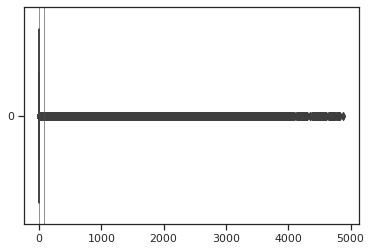

In [62]:
sns.boxplot(per_samp_DP_chr1H, orient="h", whis=1.5, dodge=True)
plt.axvline(x=5, color='#4A4A48', linewidth=0.6)
plt.axvline(x=86, color='#4A4A48', linewidth=0.6)

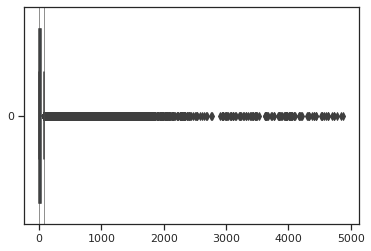

In [63]:
sns.boxplot(per_samp_DP_known, orient="h", whis=1.5, dodge=True)
plt.axvline(x=5, color='#4A4A48', linewidth=0.6)
plt.axvline(x=86, color='#4A4A48', linewidth=0.6)

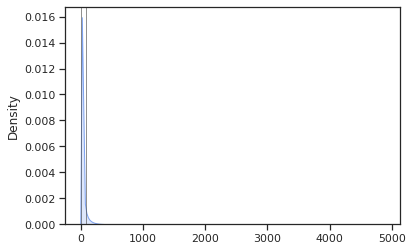

In [64]:
sns.kdeplot(per_samp_DP_known, fill=True,
         color = '#7ea3f1')
plt.axvline(x=5, color='#4A4A48', linewidth=0.6)
plt.axvline(x=86, color='#4A4A48', linewidth=0.6)

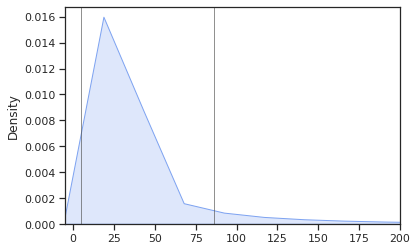

In [65]:
# Zoomed in
sns.kdeplot(per_samp_DP_known, fill=True,
         color = '#7ea3f1')
plt.xlim(-5, 200)
plt.axvline(x=5, color='#4A4A48', linewidth=0.6)
plt.axvline(x=86, color='#4A4A48', linewidth=0.6)

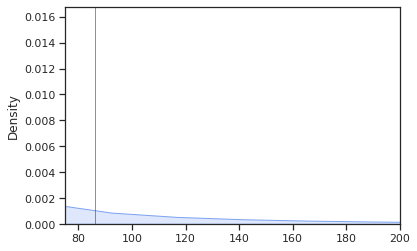

In [66]:
# Zoomed in
sns.kdeplot(per_samp_DP_known, fill=True,
         color = '#7ea3f1')
plt.xlim(75, 200)
plt.axvline(x=5, color='#4A4A48', linewidth=0.6)
plt.axvline(x=86, color='#4A4A48', linewidth=0.6)

Now, check per sample GQ.

In [67]:
# Pull per sample GQ
per_samp_GQ_chr1H = callset['calldata/GQ'][:].flatten()
per_samp_GQ_known = callset_known['calldata/GQ'][:].flatten()

In [68]:
per_samp_GQ_chr1H

array([99, 51, 99, ..., -1, -1, -1], dtype=int8)

In [69]:
summary_stats(per_samp_GQ_chr1H, 'per sample GQ', 5, 95)

Given 1719678306 variants, we have the following stats for per sample GQ:
Mean: 3.307869            
Minimum: -1.000000
Maximum: 99.000000
St. Deviation: 15.003826
5th percentile: -1.000000
95th percentile: 21.000000



In [70]:
summary_stats(per_samp_GQ_known, 'per sample GQ', 5, 95)

Given 25955008 variants, we have the following stats for per sample GQ:
Mean: 52.991817            
Minimum: -1.000000
Maximum: 99.000000
St. Deviation: 37.413650
5th percentile: -1.000000
95th percentile: 99.000000



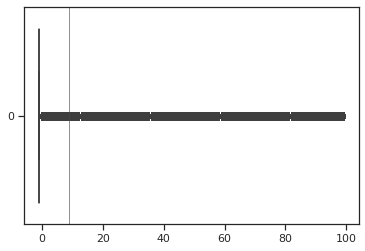

In [71]:
sns.boxplot(per_samp_GQ_chr1H, orient="h", whis=1.5, dodge=True)
plt.axvline(x=9, color='#4A4A48', linewidth=0.6)

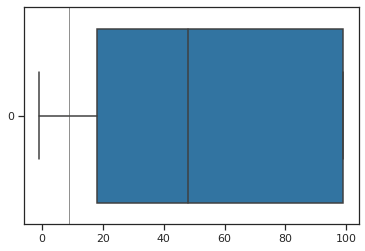

In [72]:
sns.boxplot(per_samp_GQ_known, orient="h", whis=1.5, dodge=True)
plt.axvline(x=9, color='#4A4A48', linewidth=0.6)

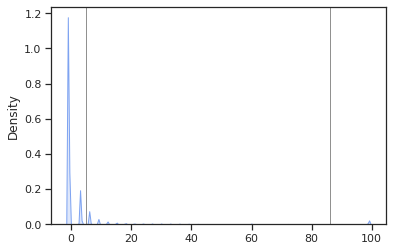

In [73]:
sns.kdeplot(per_samp_GQ_chr1H, fill=True,
         color = '#7ea3f1')
plt.axvline(x=5, color='#4A4A48', linewidth=0.6)
plt.axvline(x=86, color='#4A4A48', linewidth=0.6)

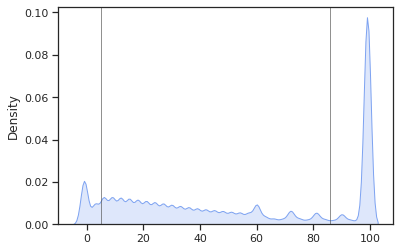

In [74]:
sns.kdeplot(per_samp_GQ_known, fill=True,
         color = '#7ea3f1')
plt.axvline(x=5, color='#4A4A48', linewidth=0.6)
plt.axvline(x=86, color='#4A4A48', linewidth=0.6)